# Practice Session 03: Find near-duplicates using shingling

Author: Tània Pazos Puig

E-mail: tania.pazos01@estudiant.upf.edu

Date: 08/10/2024

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [47]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "data/covid-lockdown-catalonia/CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

The code below defines a function to implement Jaccard similarity between two lists.

In [48]:
def jaccard_similarity(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    # Avoid division by zero
    if(len(union) == 0): 
        return 0.0
    
    return len(intersection) / len(union)

Now we perform the following test cases:

1. Two arrays for which the jaccard similarity is 0.5
1. Two arrays for which the jaccard similarity is 0.75
1. Two empty arrays should have jaccard similarity 0.0
1. Two arrays for which the jaccard similarity is 1.0

In [49]:
test_cases = [
    (['a', 'b', 'c'], ['b', 'c', 'd']),  
    (['a', 'e', 'i'], ['a', 'e', 'o', 'i']), 
    ([], []),
    (['f', 'g', 'l'], ['f', 'g', 'l'])
]

for i, (list1, list2) in enumerate(test_cases):
    result = jaccard_similarity(list1, list2)
    print(f"Test case {i + 1}: Jaccard similarity between {list1} and {list2} = {result:.2f}")

Test case 1: Jaccard similarity between ['a', 'b', 'c'] and ['b', 'c', 'd'] = 0.50
Test case 2: Jaccard similarity between ['a', 'e', 'i'] and ['a', 'e', 'o', 'i'] = 0.75
Test case 3: Jaccard similarity between [] and [] = 0.00
Test case 4: Jaccard similarity between ['f', 'g', 'l'] and ['f', 'g', 'l'] = 1.00


The following function `clean` cleans-up text according to this specification: <p>
1. Removing "RT " prefixes
1. Converting to lowercase
1. Romanizing text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.
1. Removing URLs, both "http" and "https" ones.
1. Removing spaces at the beginning and spaces at the end.
1. Removing anything that remains that is not a letter or digit
1. Changing double spaces to single spaces.

In [50]:
def clean(text):
    if text.startswith("RT "):
        text = text[3:] # Remove first 3 characters from text
        
    text = text.lower() # Convert to lowercase
    
    # Romanize text
    replacements = {
        "ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", 
        "à": "a", "è": "e", "ì": "i", "ò": "o", "ù": "u",
        "ä": "a", "ë": "e", "ï": "i", "ö": "o", "ü": "u",
        "ç": "c", "·": "", "l·l": "ll", "ß": "ss"
    }
    
    for char, replacement in replacements.items():
         text = text.replace(char, replacement)
    
    # Remove anything that starts with "http" 
    # followed by one or more non-white space characters
    text = re.sub(r'http\S+', '', text)
    
    # Remove spaces at the beginning and at the end
    text = text.strip()
    
    # Remove anything that is not a letter or a digit
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Change double spaces to single spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

We pass five different texts to our function, including punctuation, non-Roman characters, URLs, etc. in order to test it.

In [51]:
texts = ["RT i am Tània and i love watching https://youtube.com ",
    "RT HOLA SÓC UN ESTUDIANT DE   CAÇADOR VULL AIGÜES I ÀMBITS$/ ", 
    "RT  colibrí Ò https://upf.edu",
    "RT learn more ABOUT caçadors ó leñadores I clorofil·la&! ", 
    "RT @/t ù !!! http:youtube.com  "
]

for i, text in enumerate(texts, 1):
    cleaned_text = clean(text)
    print(f"Test Case {i}: Original: {text}")
    print(f"Test Case {i}: Cleaned:  {cleaned_text}\n")

Test Case 1: Original: RT i am Tània and i love watching https://youtube.com 
Test Case 1: Cleaned:  i am tania and i love watching

Test Case 2: Original: RT HOLA SÓC UN ESTUDIANT DE   CAÇADOR VULL AIGÜES I ÀMBITS$/ 
Test Case 2: Cleaned:  hola soc un estudiant de cacador vull aigues i ambits

Test Case 3: Original: RT  colibrí Ò https://upf.edu
Test Case 3: Cleaned:  colibri o

Test Case 4: Original: RT learn more ABOUT caçadors ó leñadores I clorofil·la&! 
Test Case 4: Cleaned:  learn more about cacadors o lenadores i clorofilla

Test Case 5: Original: RT @/t ù !!! http:youtube.com  
Test Case 5: Cleaned:  t u 



# 2. Implement an n-gram extractor

The code below implements the function `ngrams(text,size)`, which produces all sub-sequences of `size` words present in the text.

In [52]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    
    ngrams = []
    
    # Keep words with at least 3 characters
    filt = [word for word in tokens if len(word) >= MIN_TOKEN_LENGTH]
    
    # Create n-grams of size from the filtered tokens
    ngrams = [' '.join(filt[i:i+size]) for i in range(len(filt) - size + 1)]

    return ngrams

We perform some tests.

In [53]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

The following code computes the time in seconds that it takes to compare all first *limit* messages against all first *limit* messages in the array.

In [8]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc1
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Below we create a plot in which we have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 5.

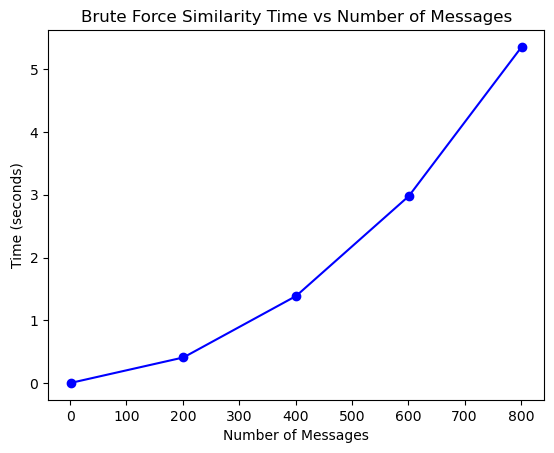

In [9]:
# X-axis values: number of messages to check
total_messages = len(messages)
# Ensure limit is never greater than total_messages
x_values = range(1, len(messages) + 1, 200)

# Y-axis values: time taken for each x
y_values = [time_brute_force_similarities(messages, limit, 5) for limit in x_values]

plt.plot(x_values, y_values, marker='o', linestyle='-', color='blue')

plt.title("Brute Force Similarity Time vs Number of Messages")
plt.xlabel("Number of Messages")
plt.ylabel("Time (seconds)")

plt.show()

The plot clearly shows that as the number of messages increases, the time taken to perform the brute force similarity computations also increases. What is more, if `n` is the number of messages, the time complexity is approximately O(n<sup>2</sup>). This can be explained because the brute force algorithm compares each message to every other message. As a result, for small values of x the time stays at a relatively low value; however, when the number of messages approaches 1000, the time taken is significantly higher. <p> Given that the brute force similarity has quadratic time complecity, if n is the number of messages, the time taken is proportional to n<sup>2</sup>. Looking at the plot, we see that the time taken for 500 messages is approximately 2 seconds. Hence, to approximate how long it would take to run the algorithm with the entire input matrix (35500 messages), we first compute the ratio of their squares. <p> Scaling factor = &nbsp; <span>&#40; <sup>35500</sup>&frasl;<sub>500</sub> &#41; <sup>2</sup> = 71<sup>2</sup> = 5041,
</span>
</p>which indicates that processing 35500 messages take 5041 times longer than processing 500 messages. Hence, <p> Time for the entire matrix = 2 seconds &times; 5041 = 10082 seconds, <p>which is 2 hours, 48 minutes, and 2 seconds.

# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

## 4.1 Create list of all ngrams

The following code creates:
* the dictionary `ngram_to_index`, which converts an ngram to an index (a row number),
* the dictionary `index_to_ngram`, which cinverts an index to an ngram, and
* the variable `num_distinct_ngrams`, which contains the number of distinct ngrams.
* the list `valid_messages`, which stores the messages (documents) containing at least one ngram of size NGRAM_SIZE, filtering out those documents without any valid ngrams (either because they are too short or due to the cleaning process).

In [54]:
NGRAM_SIZE = 4

def ngram_to_index(messages):
    
    ngram_to_index = {}
    index_to_ngram = {}
    next_index = 0 # First available index
    
    valid_messages = [] # Store messages with valid ngrams
    
    for message in messages:
        all_ngrams = ngrams(message, NGRAM_SIZE)
        
        has_valid_ngram = False
        for ngram in all_ngrams:
            if ngram not in ngram_to_index: # Distinct ngram found
                ngram_to_index[ngram] = next_index
                index_to_ngram[next_index] = ngram
                next_index += 1
            has_valid_ngram = True # Ngram of size NGRAM_SIZE
    
        # Only keep documents (messages) with at least one ngram of size NGRAM_SIZE
        if has_valid_ngram:
            valid_messages.append(message)

    num_distinct_ngrams = next_index
    
    return ngram_to_index, index_to_ngram, num_distinct_ngrams, valid_messages

In [55]:
ngram_to_index_dict, index_to_ngram_dict, num_distinct_ngrams, valid_messages = ngram_to_index(messages)

print("Number of valid documents: ", len(valid_messages))
print("Number of distinct n-grams: ", num_distinct_ngrams)

Number of valid documents:  9880
Number of distinct n-grams:  54620


We now test our function by printing the `ngram_to_index` of the strings `els restaurants han reduir` and `supera fins tot mateix` and the `index_to_ngram` of the returned index.

In [56]:
index1 = ngram_to_index_dict['els restaurants han reduir']
index2 = ngram_to_index_dict['supera fins tot mateix']

print("els restaurants han de reduir: index", index1)
print("supera fins tot mateix: index", index2)

string1 = index_to_ngram_dict[14]
string2 = index_to_ngram_dict[36]

print("index 14:", string1)
print("index 36:", string2)

els restaurants han de reduir: index 14
supera fins tot mateix: index 36
index 14: els restaurants han reduir
index 36: supera fins tot mateix


## 4.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row is an n-gram, and each column is a document. Note that we will use the `valid_messages` array to create the matrix.

In [57]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(valid_messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 54620 rows (distinct shingles) x 9880 columns (distinct documents)


The following code completes the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`.

In [58]:
for docid in range(len(valid_messages)):
    message = valid_messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram in ngram_to_index_dict:
            # Get which row in the matrix corresponds to the ngram
            ngram_index = ngram_to_index_dict[ngram]
            M_ngram_doc[ngram_index, docid] = True

Below we measure the density of this matrix, as a percentage.

In [59]:
num_non_zeroes = np.sum(M_ngram_doc) # Number of True values

total_cells = M_ngram_doc.shape[0] * M_ngram_doc.shape[1]

density_percentage = (num_non_zeroes / total_cells) * 100

print("Density of the matrix: %.4f%%" % density_percentage)

Density of the matrix: 0.0206%


Finally, we print documents 16 and 941 of the `M_ngram_doc` matrix.

In [60]:
docid1 = 16
docid2 = 941

# Ensure valid docids
if docid1 < len(valid_messages) and docid2 < len(valid_messages):

    for docid in [docid1, docid2]:
        clean_message = clean(valid_messages[docid])
        # Get all the rows (n-grams) for the document with docid
        doc_column = M_ngram_doc[:, docid]

        # Get positions of non-zero entries
        non_zero_indices = np.where(doc_column == True)[0]
        
        print(f"\nPositions of non-zeros in column of docid {docid}\n")
        
        print(f"Clean message:\n", clean_message)
        
        non_zero_ngrams = [f"{index} ({index_to_ngram_dict[index]})" for index in non_zero_indices]
        print("\nNon-zeros in corresponding row:\n", non_zero_ngrams)   
else:
    print("One of the document IDs is out of range.")


Positions of non-zeros in column of docid 16

Clean message:
 emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding row:
 ['178 (emergenciescat demana ciutadania limitar)', '179 (demana ciutadania limitar maxim)', '180 (ciutadania limitar maxim pot)', '181 (limitar maxim pot evitar)', '182 (maxim pot evitar desplacaments)', '183 (pot evitar desplacaments cap)', '184 (evitar desplacaments cap setmana)', '185 (desplacaments cap setmana tot)', '186 (cap setmana tot que)', '187 (setmana tot que sigui)']

Positions of non-zeros in column of docid 941

Clean message:
 vpartal els mossos diuen que es mes senzill confinar el principat que diverses ciutats a la vegada

Non-zeros in corresponding row:
 ['457 (els mossos diuen que)', '458 (mossos diuen que mes)', '459 (diuen que mes senzill)', '460 (que mes senzill confinar)', '461 (mes senzill confinar principat)', '462 (senzill confinar princ

# 3. Implement a permutation generator

We will now implement the function `random_permutation(k)`, which  generates a random permutation of the array `[0, 2, 3, ..., k-1]`.

In [61]:
def random_permutation(k):
    arr = list(range(k)) # Create list with elements from 0 to k-1
    
    random.shuffle(arr)
    
    return arr

In [62]:
print(random_permutation(20))

[16, 12, 11, 5, 0, 2, 9, 13, 7, 17, 10, 4, 8, 15, 19, 14, 1, 3, 6, 18]


To further test our function, the follwing code prints two lists in the same ordering, so that *alpha* is in the same position as *test1*, *gamma* in the same position as *test2*, and so on.

In [63]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['1 (test1)', '5 (test5)', '4 (test4)', '3 (test3)', '2 (test2)']
['1 (alpha)', '5 (epsilon)', '4 (delta)', '3 (beta)', '2 (gamma)']

Test another permutation
['5 (test5)', '2 (test2)', '1 (test1)', '3 (test3)', '4 (test4)']
['5 (epsilon)', '2 (gamma)', '1 (alpha)', '3 (beta)', '4 (delta)']


# 4. Compute the signature of each document

We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of valid documents.

First, we create the permutations and store them in an array of arrays named `permutations`.

In [64]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 4967, 12576, 50629, 13165, ...
Permutation 1: 32435, 39357, 47720, 17289, ...
Permutation 2: 14910, 3181, 733, 50230, ...
Permutation 3: 20120, 42491, 41841, 30619, ...
Permutation 4: 16616, 1706, 34891, 38223, ...


Now, we implement the signature construction. The matrix `M_signature_doc` contains in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

To do so, the following function finds the first n-gram that appears in a document, according to the ordering defined by a permutation.

In [65]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

The code below creates the `M_signature_doc` matrix.

In [66]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(valid_messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num + 1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    
    for docid in range(len(valid_messages)):
        if docid % 1000 == 0:  
            print("- Scanning document %d of %d" % (docid, len(valid_messages)))
        
        # Find the first n-gram present
        first_ngram_id = find_first_one(docid, permutation)
        
        # Store the result in the M_signature_doc matrix
        M_signature_doc[permutation_num, docid] = first_ngram_id

Creating signatures for permutation 1/5
- Scanning document 0 of 9880
- Scanning document 1000 of 9880
- Scanning document 2000 of 9880
- Scanning document 3000 of 9880
- Scanning document 4000 of 9880
- Scanning document 5000 of 9880
- Scanning document 6000 of 9880
- Scanning document 7000 of 9880
- Scanning document 8000 of 9880
- Scanning document 9000 of 9880
Creating signatures for permutation 2/5
- Scanning document 0 of 9880
- Scanning document 1000 of 9880
- Scanning document 2000 of 9880
- Scanning document 3000 of 9880
- Scanning document 4000 of 9880
- Scanning document 5000 of 9880
- Scanning document 6000 of 9880
- Scanning document 7000 of 9880
- Scanning document 8000 of 9880
- Scanning document 9000 of 9880
Creating signatures for permutation 3/5
- Scanning document 0 of 9880
- Scanning document 1000 of 9880
- Scanning document 2000 of 9880
- Scanning document 3000 of 9880
- Scanning document 4000 of 9880
- Scanning document 5000 of 9880
- Scanning document 6000 of 988

We now test our code by checking the signatures of two documents.

In [67]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21)
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24)

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema es economic ja no es nomes que primi lo economic a lo personal es que fins i tot en aixo el govern sequivoca doncs al final la factura que shaura de pagar sera mes gran ja es mes gran del que hauria sigut de fer les coses be i a temps
Ngrams        : [231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259]
Signature     : [250.0, 253.0, 244.0, 250.0, 257.0]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla seguiu les recomanacions eviteu qualsevol desplacament al maxim
Ng

# 5. Compare all pairs of signatures

We will consider that if two documents have *similarity == 1.0* they are a *full signature match*, and if two documents have *0.2 < similarity < 1.0* they are a *partial signature match*. In both cases, this may mean the documents are duplicates or near duplicates.

The following code compares all pairs of documents by their signatures, instead of by their content. In addition, it prints the following:
* All documents having at least X signature matches, considering both full matches and partial matches. X is 0.5% of the number of valid documents.
* All documents having more partial matches than full matches, where the number of partial matches is at least `min_partial_matches = 5`. This is done in order to correctly identify documents with a significant number of partial matches that do not have enough total matches to meet the 0.5% threshold.

In [105]:
is_possible_duplicate = {} # Track possible duplicates

threshold = 0.005 * len(valid_messages) # Set threshold to 0.5% of the number of documents
min_partial_matches = 5 # Minimum number of partial matches to display the document

# Iterate through all documents
for docid1 in range(len(valid_messages)):

     # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(valid_messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(valid_messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)
                
                # Compute similarity
                similarity = jaccard_similarity(signature1, signature2)
                
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = True

                elif 0.2 < similarity < 1.0:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = True
        
        total_matches = count_sig_full_matches + count_sig_partial_matches
        
        # To be able to identify tweets with a significant number of partial matches
        if count_sig_partial_matches > count_sig_full_matches and count_sig_partial_matches >= min_partial_matches:
            print(f"Document {docid1} has {count_sig_full_matches} full matches and {count_sig_partial_matches} partial matches.")
        if total_matches >= threshold:
            print(f"Document {docid1} has {count_sig_full_matches} full matches and {count_sig_partial_matches} partial matches.")

0/9880 documents scanned
Document 8 has 0 full matches and 8 partial matches.
Document 16 has 71 full matches and 18 partial matches.
Document 32 has 20 full matches and 26 partial matches.
Document 53 has 57 full matches and 0 partial matches.
Document 54 has 0 full matches and 8 partial matches.
Document 165 has 56 full matches and 0 partial matches.
Document 323 has 65 full matches and 0 partial matches.
Document 386 has 2 full matches and 7 partial matches.
Document 464 has 0 full matches and 8 partial matches.
500/9880 documents scanned
Document 635 has 10 full matches and 18 partial matches.
Document 778 has 0 full matches and 5 partial matches.
Document 835 has 0 full matches and 5 partial matches.
1000/9880 documents scanned
Document 1141 has 1 full matches and 8 partial matches.
1500/9880 documents scanned
2000/9880 documents scanned
2500/9880 documents scanned
Document 2946 has 0 full matches and 5 partial matches.
3000/9880 documents scanned
3500/9880 documents scanned
Docum

In [113]:
print_sig(valid_messages, M_ngram_doc, M_signature_doc, 5003)

Document #5003
Message       : RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK
Clean message : emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio
Ngrams        : [871, 872, 31428, 31429, 31430, 31431, 31432, 31433, 31434]
Signature     : [31433.0, 31434.0, 31429.0, 31431.0, 872.0]


Above we display the full text of the original tweet of document 5003, with 176 full matches and 0 partial matches. This suggests that the tweet was not changed when copied or re-tweeted. To understand this behaviour, it should be noted that the author of the original tweet is the official emergency organisation of the Catalan government (`emergenciescat`). Hence, rephrasing the text might cause users to doubt the reliability of the information. What is more, since it is an urgent safety message, users sharing this information wanted to spread the information quickly, and this purpose stopped them from modifying the tweet.

In [107]:
print("Original Document:")
print_sig(valid_messages, M_ngram_doc, M_signature_doc, 3730)

print("\nNear Duplicate:")
print_sig(valid_messages, M_ngram_doc, M_signature_doc, 5414)

Original Document:
Document #3730
Message       : RT @324cat: ▶️"Si tots limitéssim, restringíssim la nostra vida social en els pròxims 14 dies, podríem aturar l'epidèmia de coronavirus al…
Clean message : 324cat si tots limitessim restringissim la nostra vida social en els proxims 14 dies podriem aturar lepidemia de coronavirus al
Ngrams        : [24645, 24646, 24647, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655]
Signature     : [24648.0, 24648.0, 24650.0, 24645.0, 24649.0]

Near Duplicate:
Document #5414
Message       : RT @324cat: "Si tots limitéssim la nostra vida social els pròxims 14 dies, podríem parar l'epidèmia de coronavirus”, assegura Anna Llupià i…
Clean message : 324cat si tots limitessim la nostra vida social els proxims 14 dies podriem parar lepidemia de coronavirus assegura anna llupia i
Ngrams        : [24649, 24650, 24651, 24652, 33997, 33998, 33999, 34000, 34001, 34002, 34003, 34004, 34005]
Signature     : [33999.0, 34001.0, 24650.0, 24650.0, 24649.0]


Above we print the full message of the original tweet of document 3730, that has 0 full matches and 7 partial matches. In addition, we display document 5414, which is classified as a partial match by our function. Indeed, it can be observed that both tweets emphasize the need to restrict social interaction in the upcoming 14 days to stop the spread of coronavirus. However, there are some key differences in wording: the word "restringíssim" does not appear in tweet 5414 and tweet 5414 uses "parar" instead of "aturar". What is more, tweet 5414 includes the source of the quote, the expert Anna Llupià. These slight variations make tweets 3730 and 5414 partial matches.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>